## Error Plot for JCPexample 4

#### Poiseuille Flow in Pipe

In [1]:
import torch
import torch.nn as nn
import os
import sys

sys.path.append('../')

import numpy as np
import math
import scipy.special as bessel
from scipy.io import loadmat
import pickle
import importlib
import DRLPDE.neuralnets as neuralnets

import matplotlib.pyplot as plt
import cv2

import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['font.size'] = 12

#### Load model

In [2]:
loadmodel = 'testJCP4'

In [3]:
filename = 'Error_Plot_' + loadmodel
imagesfolder = "images/"

with open('../experiments/' + loadmodel + '_parameters.pickle', 'rb') as f:
    parameters = pickle.load(f)

with open('../experiments/'  + loadmodel + '_losses.pickle', 'rb') as f:
    losses = pickle.load(f)

with open('../experiments/'  + loadmodel + '_errors.pickle', 'rb') as f:
    errors = pickle.load(f)

problem = importlib.import_module(".JCPexample4", package='examples')

input_dim = [problem.x_dim, problem.t_dim, problem.hyper_dim]
output_dim = problem.output_dim

if parameters['neuralnetwork'] == 'FeedForward':
    MyNeuralNetwork = neuralnets.FeedForwardNN
elif parameters['neuralnetwork'] == 'Incompressible':
    MyNeuralNetwork = neuralnets.IncompressibleNN
elif parameters['neuralnetwork'] == 'ResNetIncompressible':
    MyNeuralNetwork = neuralnets.ResNetIncompressible
nn_size = parameters['nn_size']

model = MyNeuralNetwork(input_dim, output_dim, **nn_size)
model.load_state_dict(torch.load("../savedmodels/" + loadmodel + ".pt"))

<All keys matched successfully>

### Setup Variables and Calculate Error

In [4]:

### Domain Parameters
dim_space = 3
dim_full = dim_space

L_top = 1
L_bot = 0
L_rad = 1

### Pressure Gradient and Viscosity
mu = 1
pressure_grad = 5
    
######################## Plotting and Error Parameters ############

numpts_z = 50
numpts_r = 5
numpts_th = 30
    
    
### Consider making each plot one at a time to reduce the matrix required in big memeory 
xg_r, xg_th, xg_z = torch.meshgrid( torch.linspace(0, L_rad, numpts_r),
                                    torch.linspace(0, 2*math.pi, numpts_th),
                                    torch.linspace(L_bot, L_top, numpts_z))

x1g = xg_r*torch.cos(xg_th)
x2g = xg_r*torch.sin(xg_th)

xg = torch.stack( [x1g.reshape(-1), x2g.reshape(-1), xg_z.reshape(-1) ], dim=1 ).requires_grad_(True)

ug = model(xg).reshape([numpts_r, numpts_th, numpts_z, 3]).detach().cpu().numpy()

x1plot = x1g.detach().cpu().numpy()
x2plot = x2g.detach().cpu().numpy()
x3plot = xg_z.detach().cpu().numpy()

xrplot = xg_r.detach().cpu().numpy()

integral_factor = xrplot * 2*math.pi/(numpts_th-1) *L_rad/(numpts_r-1) * (L_top - L_bot)/(numpts_z -1)

u1_true = 0*x1plot
u2_true = 0*x1plot
u3_true = - pressure_grad/4/mu * (L_rad**2 - (x1plot**2 + x2plot**2))

u_true = np.stack([u1_true, u2_true, u3_true], axis=3)

L2_error = np.sqrt( np.sum( ((ug[:,:,:,0] - u1_true)**2 )*integral_factor ) \
                   + np.sum( ((ug[:,:,:,1] - u2_true)**2 )*integral_factor ) \
                    + np.sum( ((ug[:,:,:,2] - u3_true)**2 )*integral_factor ))

Linf_error = np.max(np.abs(ug - u_true))

L2_norm_true = np.sqrt( np.sum(  (u3_true**2)*integral_factor ) )
Linf_norm_true = np.max( np.abs( u3_true))

std_max = np.max( np.sqrt(np.mean( (ug[:,:,:,2] - u3_true)**2, axis=2)) )
std_min = np.min( np.sqrt(np.mean( (ug[:,:,:,2] - u3_true)**2, axis=2)) )

print("L2 Error = {:.4f}".format(L2_error))
print("Linf Error = {:.4f}".format(Linf_error))

print('Relative L2 Error = {:.4f}'.format(L2_error/L2_norm_true))
print('Relative Linf Error = {:.4f}'.format(Linf_error/Linf_norm_true))

#print(std_max)
#print(std_min)

L2 Error = 0.0892
Linf Error = 0.0757
Relative L2 Error = 0.0690
Relative Linf Error = 0.0606


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
levels = np.linspace(-1.3,0,100)
levels_errors = np.linspace(-0.1, 0.1, 100)
level_tick = np.linspace(-1.25, 0, 2)
error_tick = np.linspace(-0.1, 0.1, 3)

### Plot

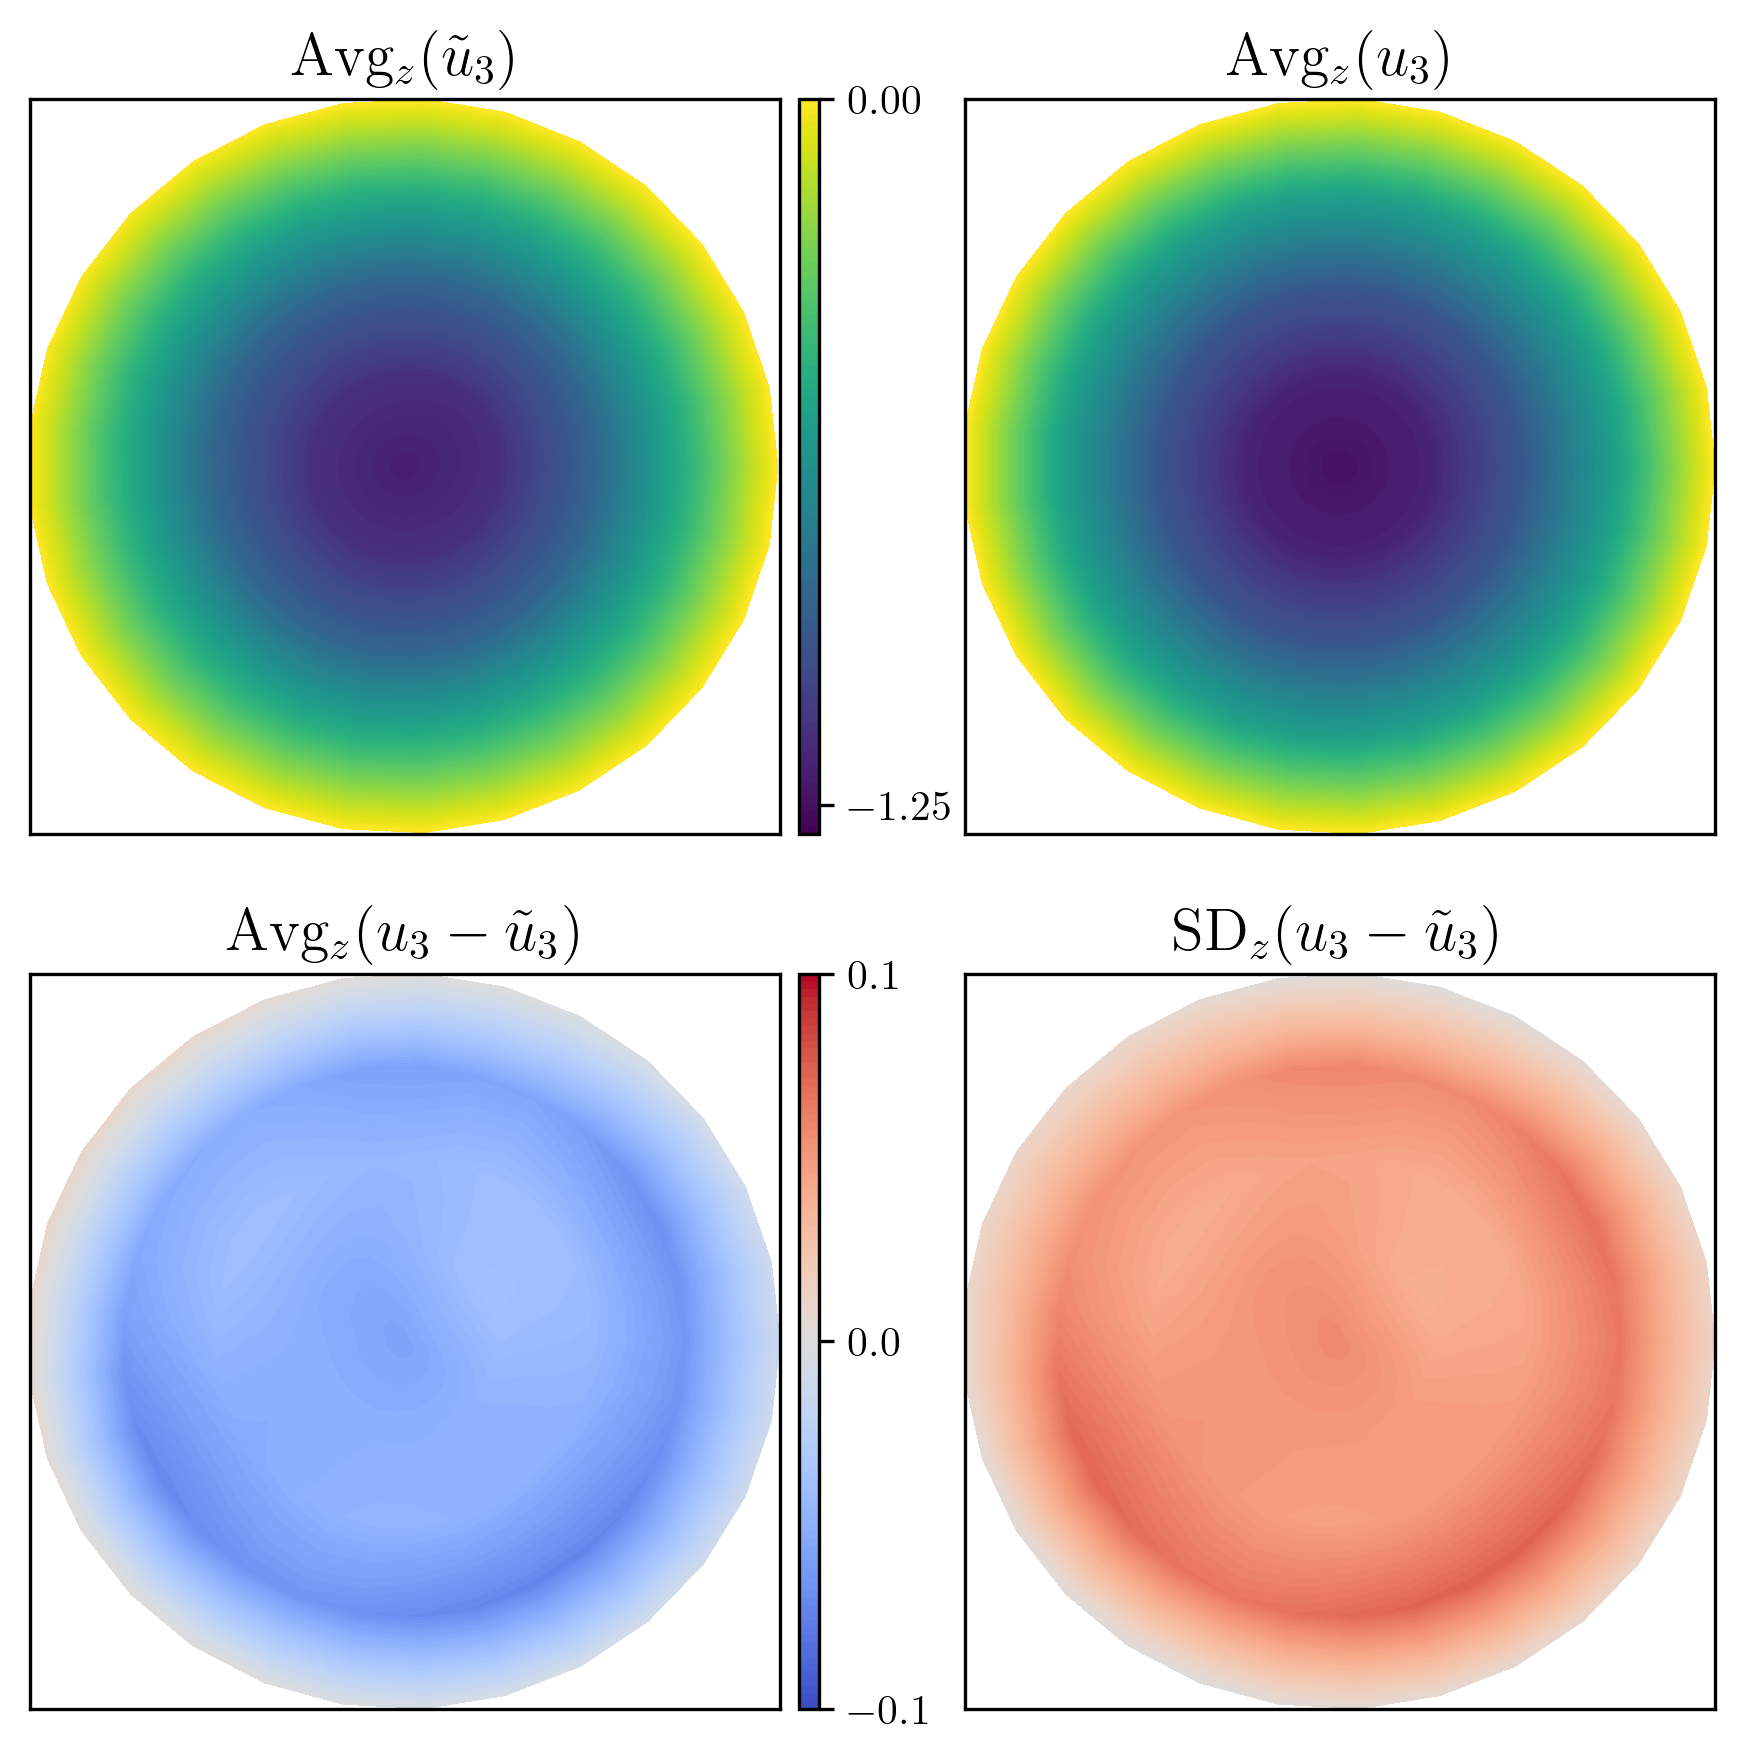

In [12]:
plt.close('all')
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=[6.4, 6.0])
plt.tight_layout(pad=1.0)

## Plot 0

contour0 = ax[0,0].contourf(x1plot[:,:,0], x2plot[:,:,0], np.mean( ug[:,:,:,2], axis=2), levels=levels, cmap = plt.cm.viridis)
ax[0,0].set_title(r'Avg$_z(\tilde{u}_3)$')

ax[0,0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar0_param = fig.add_axes(
    [ax[0,0].get_position().x1 + 0.01,
     ax[0,0].get_position().y0,
     0.01,
     ax[0,0].get_position().height])
colorbar0 = plt.colorbar(contour0, ticks=level_tick, cax = colorbar0_param)
colorbar0.ax.tick_params(labelsize=10)

## Plot 1

contour1 = ax[0,1].contourf(x1plot[:,:,0], x2plot[:,:,0], u3_true[:,:,0], levels=levels, cmap = plt.cm.viridis)
ax[0,1].set_title(r'Avg$_z(u_3)$')

ax[0,1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

## Plot 2

contour2 = ax[1,0].contourf(x1plot[:,:,0], x2plot[:,:,0], u3_true[:,:,0] - np.mean( ug[:,:,:,2], axis=2), levels_errors, cmap=plt.cm.coolwarm)
ax[1,0].set_title(r'Avg$_z( u_3 - \tilde{u}_3)$')

ax[1,0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar2_param = fig.add_axes(
    [ax[1,0].get_position().x1 + 0.01,
     ax[1,0].get_position().y0,
     0.01,
     ax[1,0].get_position().height])
colorbar2 = plt.colorbar(contour2, ticks=error_tick, cax = colorbar2_param)
colorbar2.ax.tick_params(labelsize=10)


## Plot 3

contour3 = ax[1,1].contourf(x1plot[:,:,0], x2plot[:,:,0], np.sqrt(np.mean( (ug[:,:,:,2] - u3_true)**2, axis=2)), levels_errors, cmap=plt.cm.coolwarm)
ax[1,1].set_title(r'SD$_z(u_3 - \tilde{u}_3)$')

ax[1,1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)



In [7]:
steps = range(int(parameters['trainingsteps']))
L2loss = losses[:,:,0]
Linfloss = np.sqrt(losses[:,:,1])
L2error = np.sqrt(errors[:,:,0])
Linferror = np.sqrt(np.amax(errors[:,:,1], axis=1))

print('Final Interior L2 error = {:.4f}'.format(L2error[-1,0]))
print('Final Boundary L2 error = {:.4f}'.format(L2error[-1,1]))
print('Final Linf error = {:.4f}'.format(Linferror[-1]))

Final Interior L2 error = 2.4761
Final Boundary L2 error = 0.0210
Final Linf error = 2.4468


Text(0.5, 59.88843513257575, 'number of steps')

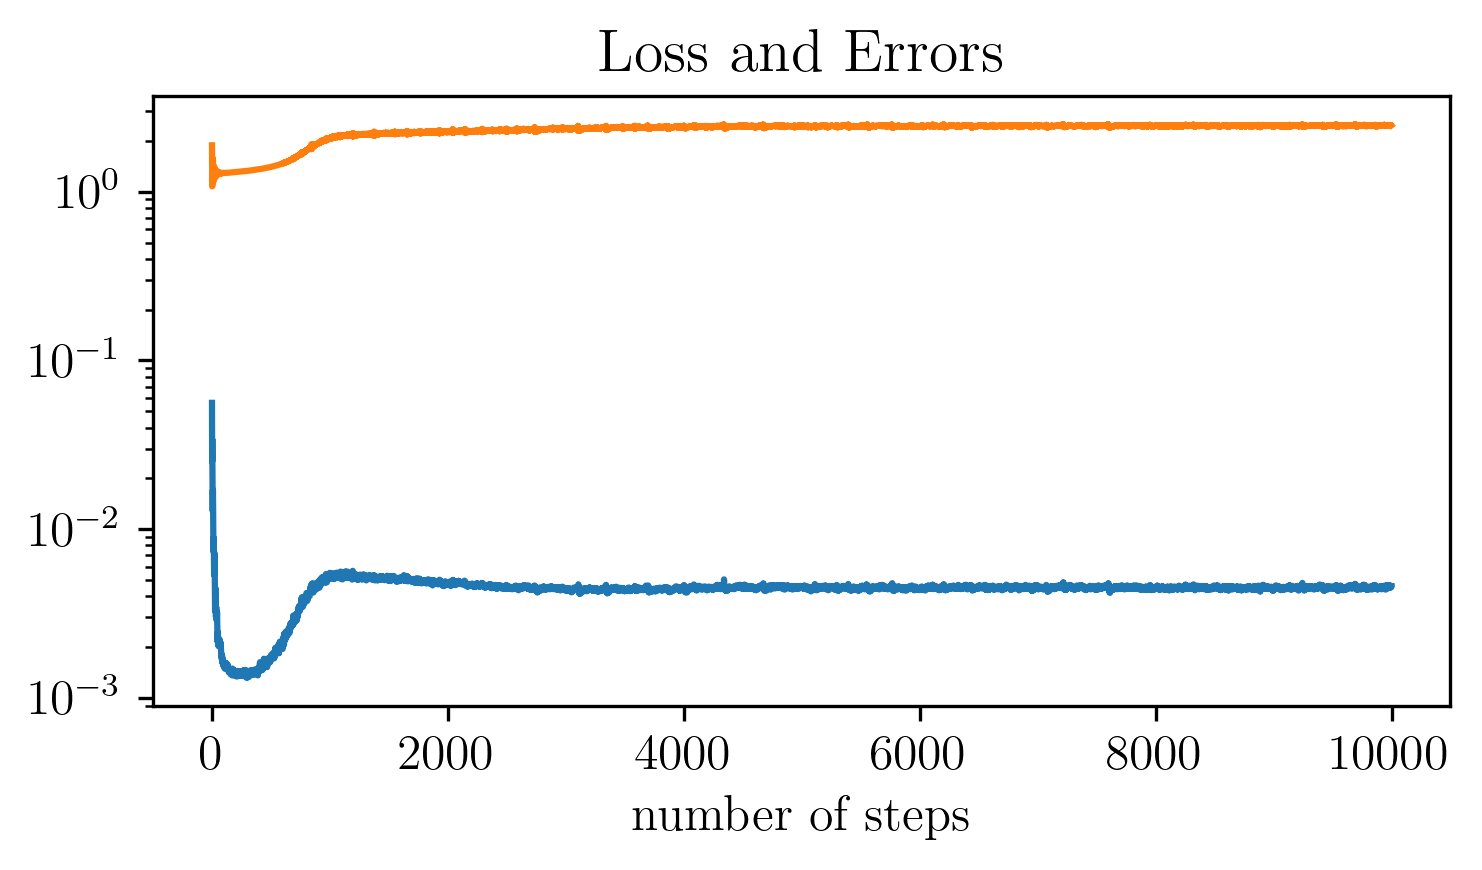

In [8]:
steps = range(int(parameters['trainingsteps']))
L2loss = losses[:,:,0]
Linfloss = np.sqrt(losses[:,:,1])
L2error = np.sqrt(errors[:,:,0])
Linferror = np.sqrt(np.amax(errors[:,:,1], axis=1))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6.4, 4])

plt.tight_layout(pad=5.0)

ax.set_title('Loss and Errors')

ax.semilogy(steps, np.sqrt(L2loss[:,0]))
#ax.semilogy(steps, np.sqrt(L2loss[:,1]))
#ax.semilogy(steps, np.sqrt(Linfloss[:,0]))
ax.semilogy(steps, L2error[:,0])
#ax.semilogy(steps, Linferror)
#ax.legend(['Interior L2 loss', 'Interior Linf loss', 'Interior L2 error', 'Interior Linf error'])
ax.set_xlabel('number of steps')

#ax[1].set_title('Comparing L2 loss and L2 error')
#ax[1].semilogy(steps, np.abs( 5.1148*L2loss - L2error) )